# Introduction

In this notebook, I explore the acc data for each user, to try to identify some patterns or things of interest.

In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction

from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# Data Preparation

## Cognitive Load Info

In [2]:
path_to_experiment_info: str = "../data.nosync/usilaughs/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=1)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
acc_data = load_processed_data(path=acc_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/67 [00:00<?, ?it/s]

Loading data:   0%|          | 0/68 [00:00<?, ?it/s]

761

Plotting user data:   0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

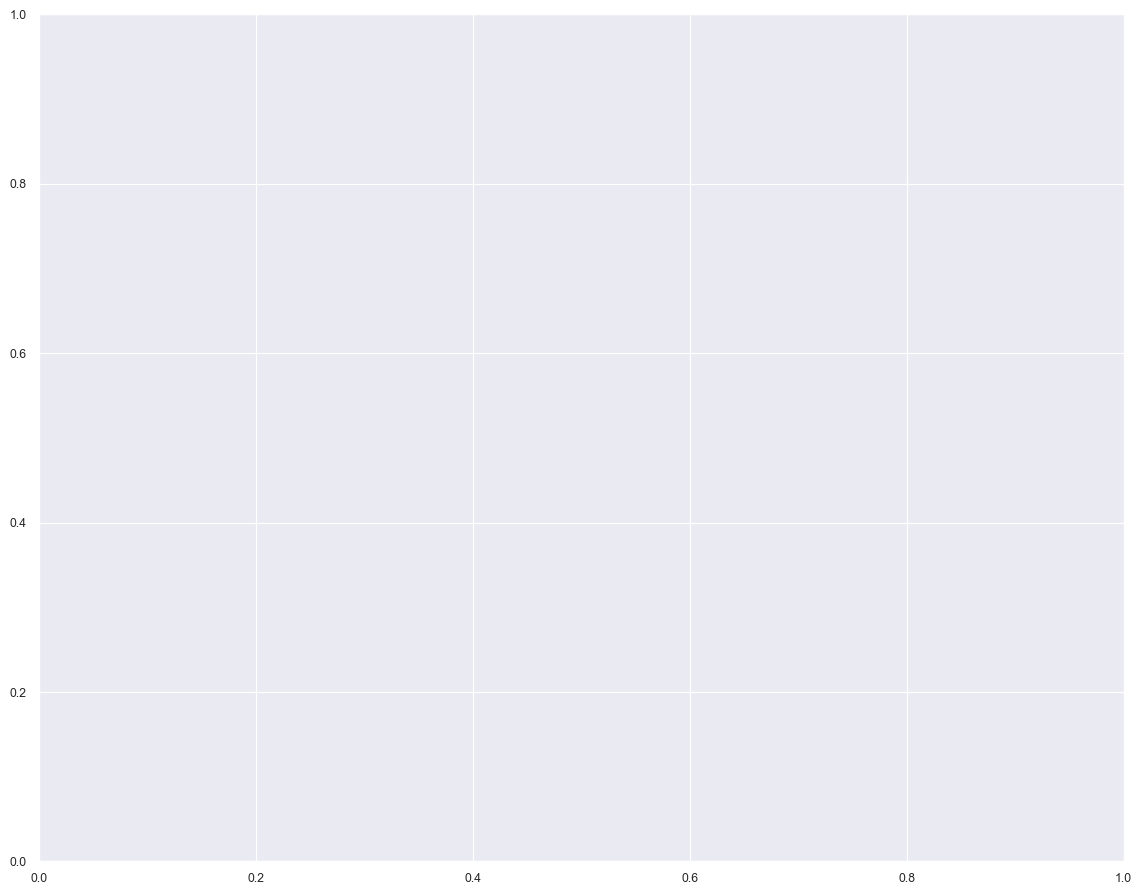

In [4]:
users = get_all_users(acc_data)
sessions_all = ["experiment"]
output_folder: str = "../visualizations/"
for user in tqdm(sorted(users), desc="Plotting user data", colour="red"):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data={"ACC": acc_data},
            user_id=user,
            signal_type='ACC',
            session_id=session,
            dataset="usi_laughs",
            experiment_info=experiment_info.to_df(),
            eda_type="mixed-EDA",
            output_folder=output_folder
        )


In [5]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())

In [6]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


# Some statistics

Here I just compute the average ACC inside the experiment. 

In [7]:
mean_res = {
    side: {
        user: acc_data[side][user].median()[0]
        for user in sorted(users_in_left_side & users_in_right_side)
    }
    for side in ["left", "right"]
}


In [8]:
display(DataFrame(mean_res))

,left,right
s037,-0.04,-0.07
s038,-0.07,-0.14
s039,-0.23,-0.30
s042,-0.05,-0.11
s043,-0.12,-0.14
s044,-0.13,-0.08
s045,-0.18,-0.20
s047,-0.16,-0.17
s048,-0.20,-0.25
s049,-0.10,-0.09


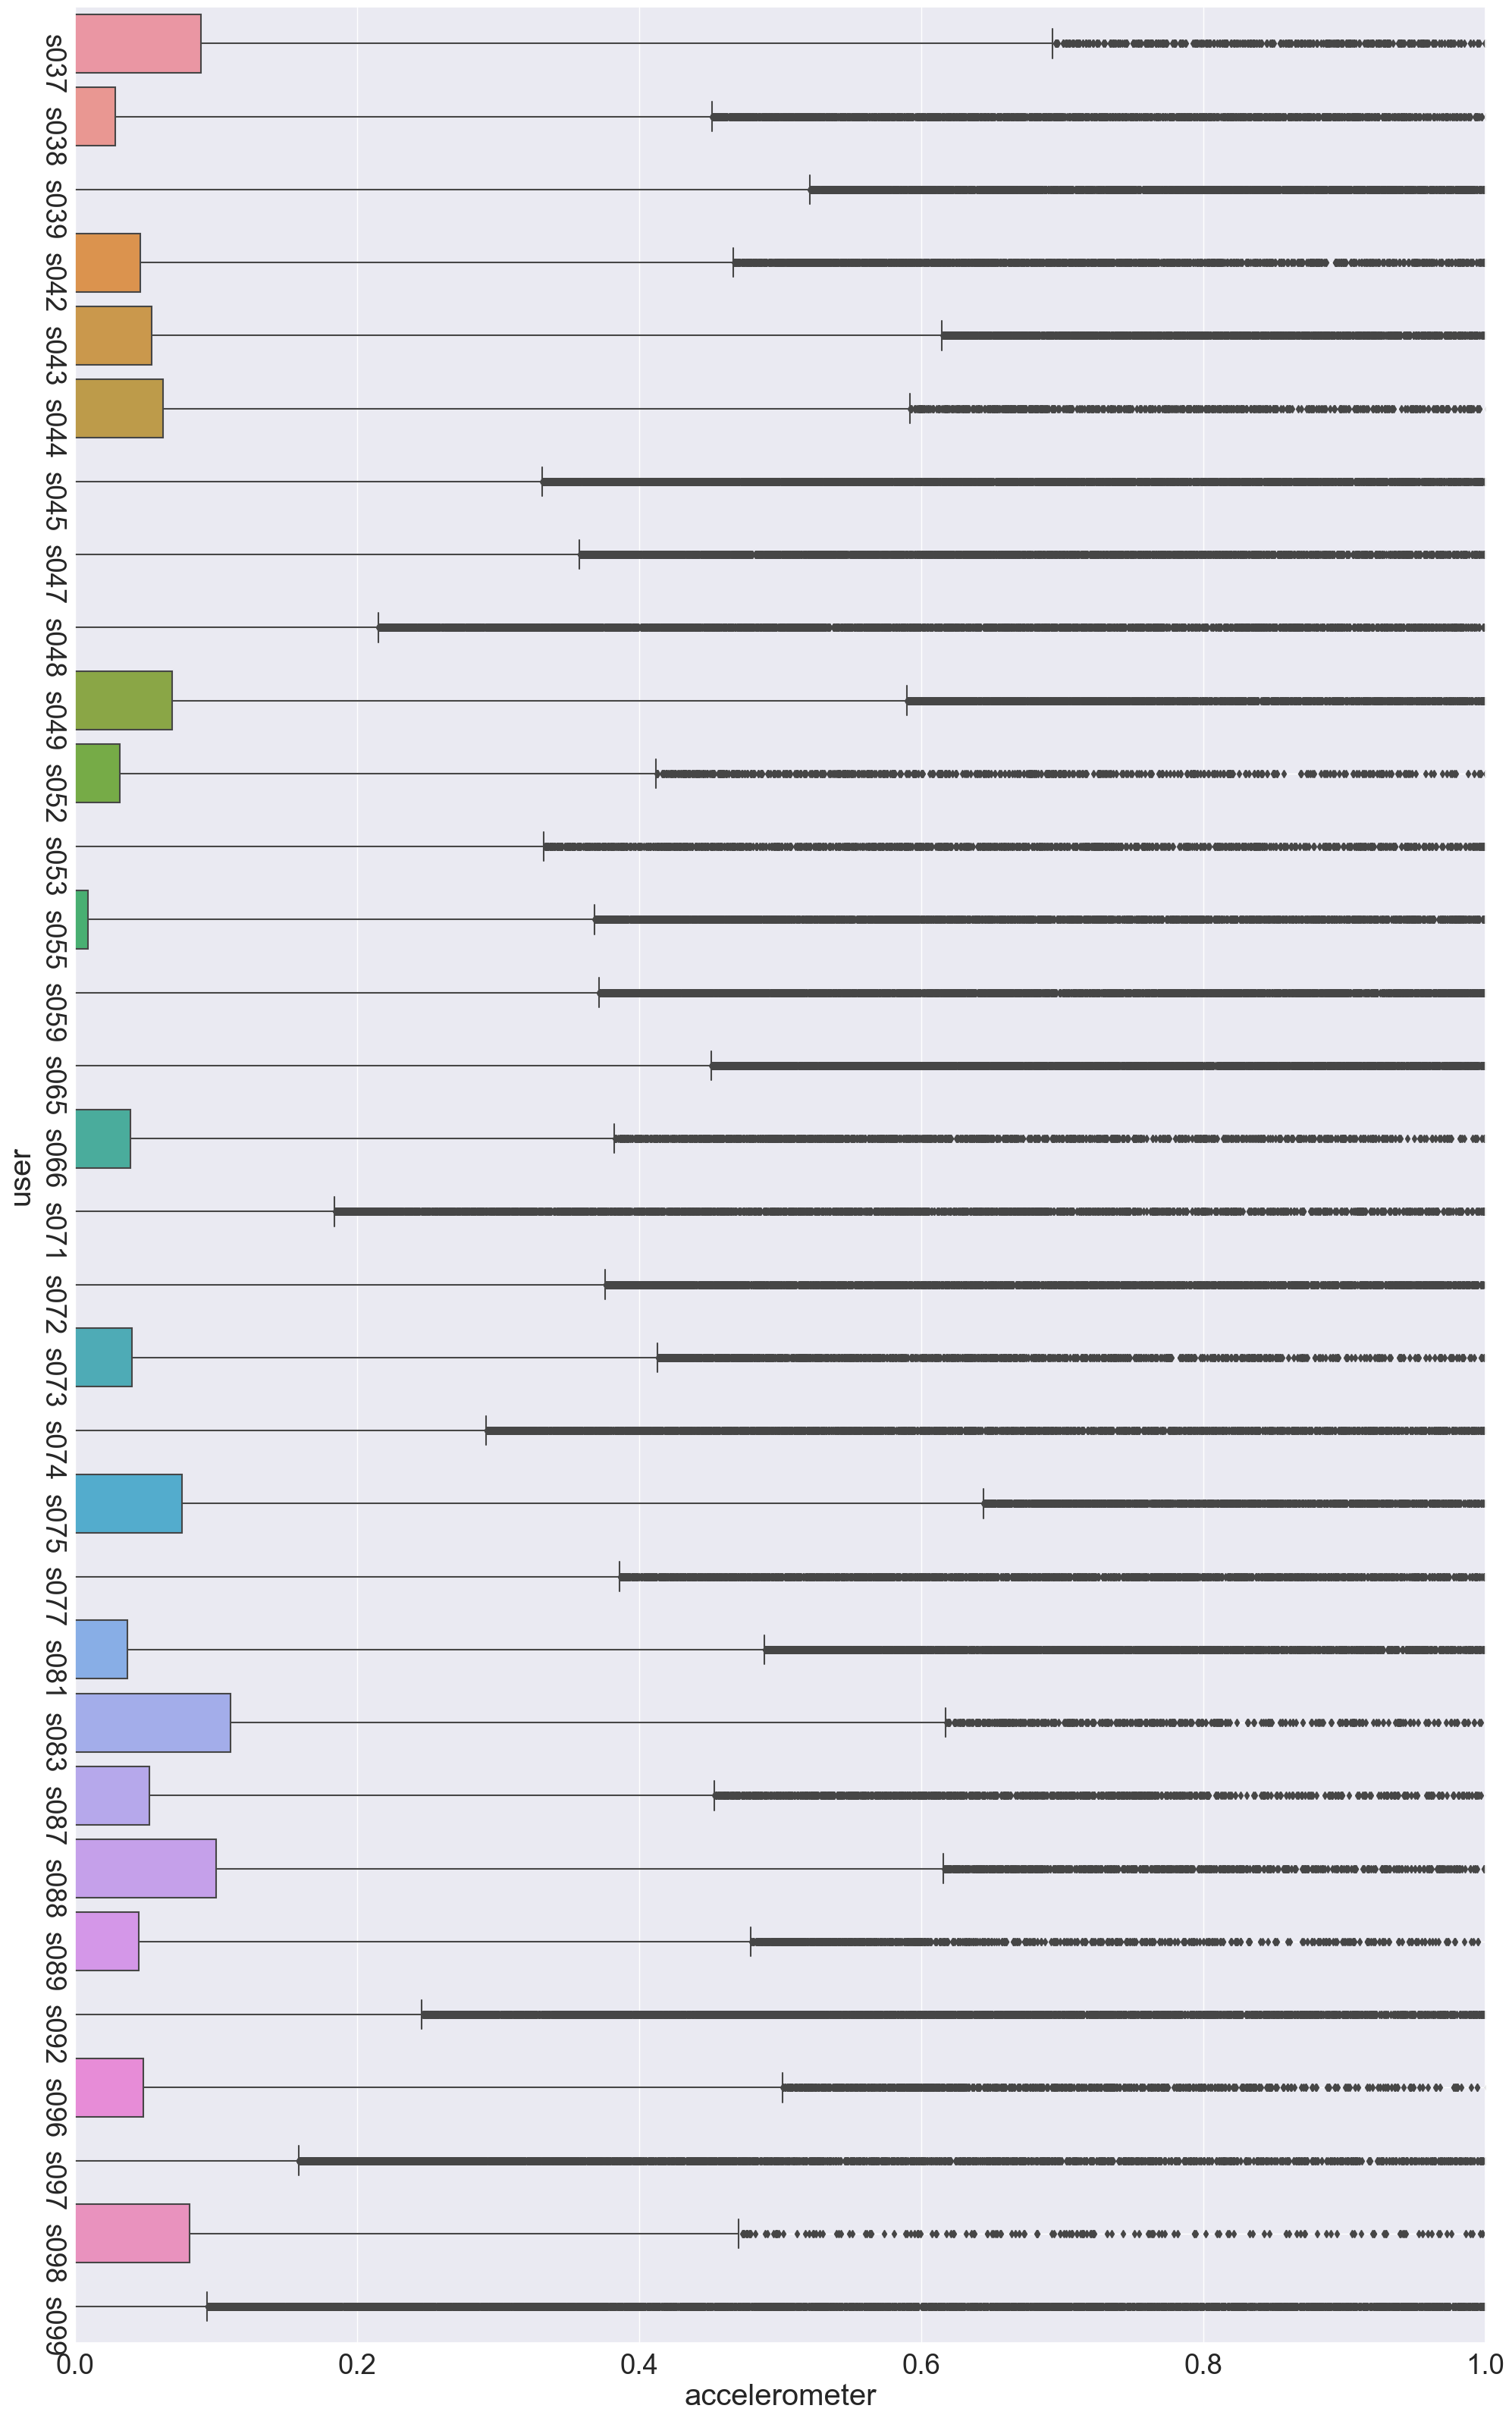

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


data = [
    (el, side, user)
    for side in ["left", "right"]
    for user in sorted(users_in_left_side & users_in_right_side)
    for el in acc_data[side][user]['ACC']
]

plt.figure(figsize=(24, 40))
sns.set_context("paper")
sns.set(font_scale=2.4)
data_to_plot = DataFrame([*data], columns=['accelerometer', "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x='accelerometer', y="user", orient='h')
ax.xaxis.grid(True)
ax.yaxis.grid(True)
# plt.title(f"Distribution of accelerometer data across users")
plt.yticks(rotation=270)
ax.set_xlim(0., 1.0)
plt.show()


There does not appear to be a correlatin between the distribution of accelerometer and the results of the classifiers. However, this distribution considers the whole experiment. I will now try to calculate some percentiles for the whole data taken together, and then use this to implement some naive artefact detection.

In [92]:
data_to_plot['accelerometer'].quantile(0.95)

0.6293232138619698